# DeepAR on laptime&rank dataset

laptime&rank dataset
<eventid, carids, laptime (totalcars x totallaps), rank (totalcars x totallaps)>; filled with NaN

In [1]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

## Datasets


In [2]:
import pickle
with open('laptime_rank-2018.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    global_carids, laptime_data = pickle.load(f, encoding='latin1')

In [3]:
events = ['Phoenix','Indy500','Texas','Iowa','Pocono','Gateway']
events_id={key:idx for idx, key in enumerate(events)}

In [4]:
print(f"events: {events}")

events: ['Phoenix', 'Indy500', 'Texas', 'Iowa', 'Pocono', 'Gateway']


To download one of the built-in datasets, simply call get_dataset with one of the above names. GluonTS can re-use the saved dataset so that it does not need to be downloaded again: simply set `regenerate=False`.

In [5]:
laptime_data[2][2].astype(np.float32)

array([[26.0364, 24.6531, 24.3582, ...,     nan,     nan,     nan],
       [62.1349, 66.7862,     nan, ...,     nan,     nan,     nan],
       [28.33  , 26.3849, 25.3203, ...,     nan,     nan,     nan],
       ...,
       [64.83  , 58.0034,     nan, ...,     nan,     nan,     nan],
       [28.0383, 26.1015, 25.6888, ...,     nan,     nan,     nan],
       [27.296 , 26.2981, 25.0074, ...,     nan,     nan,     nan]],
      dtype=float32)

In [6]:
# global configuration
prediction_length = 50
freq = "1H"
cardinality = [len(global_carids)]
TS_LAPTIME=2
TS_RANK=3
run_ts = TS_RANK

In [7]:
from gluonts.dataset.common import ListDataset
start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series

train_set = []
test_set = []

#_data: eventid, carids, laptime array
for _data in laptime_data:
    #_train = [{'target': x.astype(np.float32), 'start': start} 
    #        for x in _data[2][:, :-prediction_length]]
    #_test = [{'target': x.astype(np.float32), 'start': start} 
    #        for x in _data[2]]
    
    #map rowid -> carno -> global_carid
    #carids = list(_data[1].values())
    #global_carid = global_carids[_data[1][rowid]]
    
    _train = [{'target': _data[run_ts][rowid, :-prediction_length].astype(np.float32), 'start': start, 
               'feat_static_cat': global_carids[_data[1][rowid]]}             
            for rowid in range(_data[run_ts].shape[0]) ]
    _test = [{'target': _data[run_ts][rowid, :].astype(np.float32), 'start': start, 
              'feat_static_cat': global_carids[_data[1][rowid]]} 
            for rowid in range(_data[run_ts].shape[0]) ]
    
    train_set.extend(_train)
    test_set.extend(_test)



In [8]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(train_set, freq=freq)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(test_set, freq=freq)

In general, the datasets provided by GluonTS are objects that consists of three main members:

- `dataset.train` is an iterable collection of data entries used for training. Each entry corresponds to one time series
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
- `dataset.metadata` contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc.

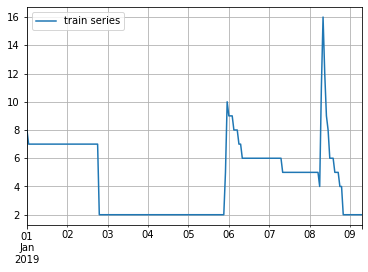

In [9]:
from gluonts.dataset.util import to_pandas
entry = next(iter(train_ds))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

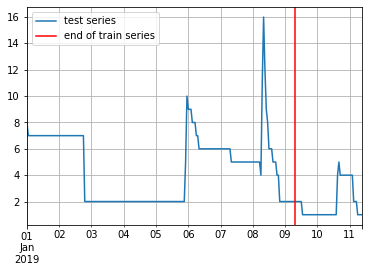

In [10]:
entry = next(iter(test_ds))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [11]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {prediction_length}")
print(f"Frequency of the time series: {freq}")

Length of forecasting window in test dataset: 50
Recommended prediction horizon: 50
Frequency of the time series: 1H


## Training an existing model (`Estimator`)

GluonTS comes with a number of pre-built models. All the user needs to do is configure some hyperparameters. The existing models focus on (but are not limited to) probabilistic forecasting. Probabilistic forecasts are predictions in the form of a probability distribution, rather than simply a single point estimate.

We will begin with GulonTS's pre-built feedforward neural network estimator, a simple but powerful forecasting model. We will use this model to demonstrate the process of training a model, producing forecasts, and evaluating the results.

GluonTS's built-in feedforward neural network (`SimpleFeedForwardEstimator`) accepts an input window of length `context_length` and predicts the distribution of the values of the subsequent `prediction_length` values. In GluonTS parlance, the feedforward neural network model is an example of `Estimator`. In GluonTS, `Estimator` objects represent a forecasting model as well as details such as its coefficients, weights, etc.

In general, each estimator (pre-built or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g., the `prediction_length`) or specific for the particular estimator (e.g., number of layers for a neural network or the stride in a CNN).

Finally, each estimator is configured by a `Trainer`, which defines how the model will be trained i.e., the number of epochs, the learning rate, etc.

In [12]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

INFO:root:Using GPU


In [39]:
estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=2*prediction_length,
    use_feat_static_cat=True,
    cardinality=cardinality,
    freq=freq,
    trainer=Trainer(ctx="gpu(2)", 
                    epochs=1, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=64
                   )
)

After specifying our estimator with all the necessary hyperparameters we can train it using our training dataset `dataset.train` by invoking the `train` method of the estimator. The training algorithm returns a fitted model (or a `Predictor` in GluonTS parlance) that can be used to construct forecasts.

In [14]:
predictor = estimator.train(train_ds)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 64/64 [00:16<00:00,  3.89it/s, avg_epoch_loss=2.1] 
INFO:root:Epoch[0] Elapsed time 16.439 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=2.100863
INFO:root:Loading parameters from best epoch (0)
INFO:root:Final loss: 2.1008627768605947 (occurred at epoch 0)
INFO:root:End model training


With a predictor in hand, we can now predict the last window of the `dataset.test` and evaluate our model's performance.

GluonTS comes with the `make_evaluation_predictions` function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:

- Removes the final window of length `prediction_length` of the `dataset.test` that we want to predict
- The estimator uses the remaining data to predict (in the form of sample paths) the "future" window that was just removed
- The module outputs the forecast sample paths and the `dataset.test` (as python generator objects)

In [15]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [16]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

First, we can convert these generators to lists to ease the subsequent computations.

In [17]:
forecasts = list(forecast_it)
tss = list(ts_it)

We can examine the first element of these lists (that corresponds to the first time series of the dataset). Let's start with the list containing the time series, i.e., `tss`. We expect the first entry of `tss` to contain the (target of the) first time series of `dataset.test`.

In [18]:
# first entry of the time series list
ts_entry = tss[0]

In [19]:
len(ts_entry)

250

In [20]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[-10:]).reshape(-1,)

array([4., 4., 4., 2., 2., 2., 1., 1., 1., 1.], dtype=float32)

In [21]:
# first entry of dataset.test
dataset_test_entry = next(iter(test_ds))

In [22]:
# first 5 values
dataset_test_entry['target'][-10:]

array([4., 4., 4., 2., 2., 2., 1., 1., 1., 1.], dtype=float32)

In [23]:
len(tss[0])

250

In [24]:
forecasts[0].samples.shape

(100, 50)

In [25]:
# Indy500 Car 12 WillPower
ts_entry = tss[52]
ts_entry

,0
2019-01-01 00:00:00,27.0
2019-01-01 01:00:00,24.0
2019-01-01 02:00:00,24.0
2019-01-01 03:00:00,24.0
2019-01-01 04:00:00,24.0
...,...
2019-01-09 03:00:00,2.0
2019-01-09 04:00:00,15.0
2019-01-09 05:00:00,17.0
2019-01-09 06:00:00,17.0


The entries in the `forecast` list are a bit more complex. They are objects that contain all the sample paths in the form of `numpy.ndarray` with dimension `(num_samples, prediction_length)`, the start date of the forecast, the frequency of the time series, etc. We can access all these information by simply invoking the corresponding attribute of the forecast object.

In [26]:
# first entry of the forecast list
forecast_entry = forecasts[52]

In [27]:
forecast_entry.samples[0,:]

array([12.609041 , 14.857639 , 12.460515 , 15.205414 , 13.966553 ,
       14.552215 , 14.004252 , 12.759359 , 13.831731 , 12.315809 ,
       13.5128765, 13.265121 ,  6.3159614, 12.783538 , 12.542195 ,
       11.921409 ,  8.690061 , 13.7592   , 11.138319 , 11.868011 ,
       12.850292 , 12.406536 , 12.463973 , 12.479267 , 11.600293 ,
       13.197301 , 17.822708 , 12.423469 , 13.429987 , 12.528228 ,
       10.158975 , 12.870495 , 12.7072525, 16.298351 , 13.482619 ,
       12.860258 , 16.144854 , 13.354847 , 13.695052 , 15.222259 ,
       14.183968 ,  7.9932575, 12.268167 , 11.511748 , 12.470324 ,
       10.838871 , 12.625419 ,  9.6190815, 10.3886175, 10.726427 ],
      dtype=float32)

In [28]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 50)
Start date of the forecast window: 2019-01-07 06:00:00
Frequency of the time series: 1H


We can also do calculations to summarize the sample paths, such computing the mean or a quantile for each of the 48 time steps in the forecast window.

In [29]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [13.351933  13.430032  13.035907  12.573752  12.607952  12.431803
 13.150517  13.040439  12.673831  12.539699  12.87422   12.752693
 12.384979  12.378199  12.662849  12.723791  13.386626  12.053753
 11.165609  12.42595   12.785395  12.613616  13.341313  12.839669
 12.825244  12.215976  13.046068  12.575401  13.124974  12.570835
 12.286119  12.187491  12.18065   11.941194  12.289546  11.7733755
 11.493773  12.237122  11.847287  12.525093  11.582079  10.837931
 10.236334  10.220241  10.523907  10.624568  10.053447  10.423648
 10.378766  10.504932 ]
0.5-quantile (median) of the future window:
 [13.019697  13.442818  12.8268385 12.087721  12.595896  12.543894
 12.959172  12.809021  12.623326  12.4857855 12.682126  12.494748
 12.504614  12.566085  12.542195  12.449027  13.407122  11.725311
 11.138319  12.5051    12.5352    12.684471  13.034642  12.715641
 12.554827  11.949671  12.701969  12.701547  13.089849  12.587446
 12.406862  12.518386  12.13229   11.811192 

`Forecast` objects have a `plot` method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a "fan chart".

In [30]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

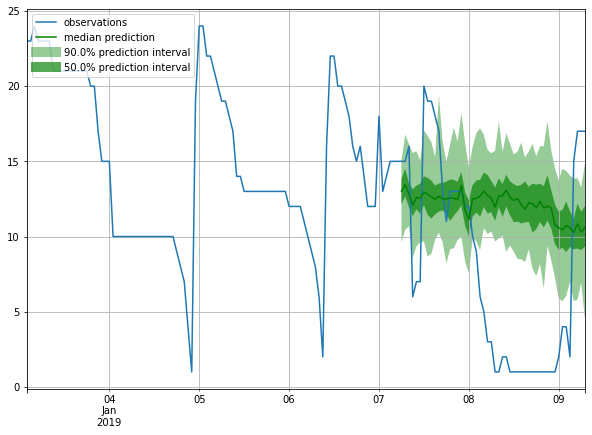

In [31]:
plot_prob_forecasts(ts_entry, forecast_entry)

We can also evaluate the quality of our forecasts numerically. In GluonTS, the `Evaluator` class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [32]:
from gluonts.evaluation import Evaluator

In [33]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 153/153 [00:01<00:00, 139.62it/s]
/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/pandas/core/dtypes/cast.py:1289: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(values, dtype=dtype, copy=copy)


Aggregate metrics aggregate both across time-steps and across time series.

In [34]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 12.021410673912257,
    "abs_error": 13300.203194141388,
    "abs_target_sum": 55147.0,
    "abs_target_mean": 10.214919583363173,
    "seasonal_error": 2.6918673177312615,
    "MASE": 1.2293183487266053,
    "sMAPE": 0.31394052883241697,
    "MSIS": 20.432425702149523,
    "QuantileLoss[0.1]": 5833.859597754479,
    "Coverage[0.1]": 0.09964083139004457,
    "QuantileLoss[0.5]": 13300.203197300434,
    "Coverage[0.5]": 0.30846328764160913,
    "QuantileLoss[0.9]": 9252.701577317715,
    "Coverage[0.9]": 0.6431915623079657,
    "RMSE": 3.4671906024780723,
    "NRMSE": 0.3394241701251387,
    "ND": 0.2411772751761907,
    "wQuantileLoss[0.1]": 0.10578743354587701,
    "wQuantileLoss[0.5]": 0.2411772752334748,
    "wQuantileLoss[0.9]": 0.1677825009033622,
    "mean_wQuantileLoss": 0.17158240322757135,
    "MAE_Coverage": 0.14956810622012687
}


Individual metrics are aggregated only across time-steps.

In [35]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,5.393252,102.661583,95.0,1.900000,2.039773,1.006598,0.809993,21.318465,97.140809,0.72,102.661586,0.76,31.395297,1.000000
1,NaN,4.831744,78.278183,807.0,19.682927,2.159091,0.884272,0.103712,3.321337,40.703464,0.00,78.278186,0.00,10.246677,0.829268
2,NaN,1.983144,45.780270,189.0,3.780000,2.312500,0.395937,0.260132,6.236571,12.865523,0.12,45.780267,0.62,38.361641,0.860000
3,NaN,1.485790,53.595257,118.0,2.360000,1.835227,0.584072,0.451233,3.956616,14.522511,0.32,53.595256,0.90,22.037156,1.000000
4,NaN,3.135085,84.683990,245.0,4.900000,2.113636,0.801311,0.296428,5.482303,21.094003,0.44,84.683996,1.00,33.133876,1.000000


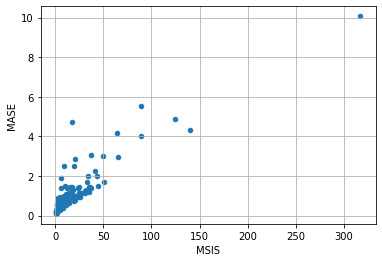

In [36]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()